In [219]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
import math
from numpy import cos,sin
from matplotlib import cm

In [220]:
controlpoints_data = pd.read_table("10160528_controlpoints.txt", sep= "\s+",  names = ["ID", "Longitude", "Latitude", "H", "h"])

In [230]:
controlpoints_data.head() #code to see the values as a proper table


,ID,Longitude,Latitude,H,h,N,adjustedN,V,VV
0,114,28.924101,41.218487,143.288,179.714,36.426,36.434691,0.008691,7.554076e-05
1,418,28.967054,41.093149,108.895,145.433,36.538,36.538284,0.000284,8.064174e-08
2,255,28.772309,41.115345,132.137,168.921,36.784,36.675432,-0.108568,1.178694e-02
3,107,28.891828,41.044772,54.128,90.741,36.613,36.644722,0.031722,1.006284e-03
4,366,29.088633,40.966692,49.993,86.510,36.517,36.394392,-0.122608,1.503280e-02


In [222]:
controlpoints_data["N"] = controlpoints_data["h"]- controlpoints_data["H"]  #ondulation value for control points is calculated and added to the table

In [223]:
testpoints_data = pd.read_table("10160528_testpoints.txt", sep= "\s+",  names = ["ID", "Longitude", "Latitude", "H", "h"])


In [231]:
testpoints_data.head()

,ID,Longitude,Latitude,H,h,N,N_from_geoid_model,v,vv
0,318,29.021809,41.190592,234.515,270.790,36.275,36.358064,0.083064,0.006900
1,79,28.808243,41.194675,151.930,188.609,36.679,36.563158,-0.115842,0.013419
2,335,28.832171,41.166263,71.920,108.614,36.694,36.588678,-0.105322,0.011093
3,8,28.944942,41.035909,16.613,53.176,36.563,36.594461,0.031461,0.000990
4,195,29.113265,41.100764,109.577,145.945,36.368,36.310398,-0.057602,0.003318


In [225]:
 testpoints_data["N"] = testpoints_data["h"]- testpoints_data["H"]  #ondulation value for test points is calculated and added to the table

In [226]:
A_matrix = [] 
for i in range (len(controlpoints_data)):
    A_matrix.append(  [1, 
                 np.cos(np.radians(controlpoints_data["Latitude"][i]))*np.cos(np.radians(controlpoints_data["Longitude"][i])),
                 np.cos(np.radians(controlpoints_data["Latitude"][i]))*np.sin(np.radians(controlpoints_data["Longitude"][i])), 
                 np.sin(np.radians(controlpoints_data["Latitude"][i]))])
A = np.matrix(A_matrix) #  design matrix 
#print(len(A))

np.savetxt('010160528_designmatrix.txt', A, delimiter='  ',header="Design matrix of the Control Points",fmt='%10.10f') #Saving as txt
L = np.transpose(np.matrix([controlpoints_data["N"].values.tolist()])) #observations matrix (N values)
#print(L)
# weight matrix P is given as 1 so not included to calculations
X_control = np.dot(np.linalg.inv(np.dot(np.transpose(A),A)),np.dot(np.transpose(A),L))  #((At*A)**(-1))*(At*L) matrix of unknowns
#print(X_control)
N_adjusted = np.dot(A,X_control) # N" = A.x
controlpoints_data["adjustedN"] = np.dot(A,X_control) #adjustment N value of control points
v = np.subtract(np.dot(A, X_control), L)  # adjustedN  V = Ax-l
controlpoints_data["V"] = np.subtract(N_adjusted,L)

#Errors
vv = []
k = 0
for i in range(len(v)):
    vvi = controlpoints_data["V"][i]*controlpoints_data["V"][i]
    vv.append([vvi])
    k = k + vvi
    i = i+1
controlpoints_data["VV"] = np.matrix(vv)
#print(len(vv))
#print(k) # Sum of VV values
u = 4 #number of unknown values x0,x1,x2,x3
rmse_control = (k/ (len(controlpoints_data)-u) )** (1/2)
print(rmse_control,'m rmse error')

#vv = np.dot(v,np.transpose(v))
#print(np.matrix([controlpoints_data["V"].values.tolist()]))





0.08590632505244178 m rmse error


In [227]:
#Error estimates of coefficients (errors of x0,x1,x2,x3)
# from Error Propogation law
N_matrix = np.dot(np.transpose(A),A)

N_matrixlist = N_matrix.tolist()
#print(N_matrix)  # 4x4
Nr_matrix = []

for i in range(len(N_matrixlist)):
    Nr_matrix.append(N_matrixlist[i][i])
    
print(Nr_matrix) # diagonal values(P0,P1,P2,P3) of the matrix since error of coefficient x0 = m0 x (Po)**(1/2) --- m0 is rmse error 0.08590632505244178
    
X_controllist = X_control.tolist()
#print(X_controllist)

X_controladj = []
for i in range(len(X_controllist)):
    X_controladj.append(rmse_control*(np.sqrt(Nr_matrix[i]))) #x0 = m0 x (Po)**(1/2)

print(X_controladj)  # deviation of x0,x1,x2,x3


[216.0, 93.90132211134338, 28.72752196568188, 93.37115592297478]
[1.2625599723369223, 0.8324554376506896, 0.4604412493408105, 0.8301020925034959]


In [236]:
#A,L,v Matrices of test points
A_matrix_test = []
for i in range (len(testpoints_data)):
    A_matrix_test.append(  [1, 
                 np.cos(np.radians(testpoints_data["Latitude"][i]))*np.cos(np.radians(testpoints_data["Longitude"][i])),
                 np.cos(np.radians(testpoints_data["Latitude"][i]))*np.sin(np.radians(testpoints_data["Longitude"][i])), 
                 np.sin(np.radians(testpoints_data["Latitude"][i]))])
    
A_test = np.matrix(A_matrix_test)
#print(A_test)

testpoints_data["N_from_geoid_model"] = np.dot(A_test,X_control) #because of A matrix of test includes phi and lam values of test points A_test is multiplied with unknown values matrix of model
L_test = np.transpose(np.matrix(testpoints_data["N"].values.tolist()))
#print(L_test)
v_test = np.subtract(np.dot(A_test,X_control),L_test)
testpoints_data["v"] = v_test

#Errors
VV = []
c = 0
for i in range(len(v_test)):
    vvi2 = testpoints_data["v"][i]*testpoints_data["v"][i]
    VV.append([vvi2])
    c = c + vvi2
    i = i+1
    
testpoints_data["vv"] = np.matrix(VV)
u = 4 #number of unknown values x0,x1,x2,x3
rmse_test = (c/ (len(testpoints_data)-u) )** (1/2)
print(rmse_test,'m rmse error')

#Saving as .txt
np.savetxt(r'controlpoints_data_with_v.txt', controlpoints_data.values, delimiter = "    ", header ="ID--------------Longitude--------Latitude-------Orthometric Height---Elipsoidal Height--------N----------adjustedN-----------v",fmt='%10.10f')
np.savetxt(r'testpoints_data_with_v.txt', testpoints_data.values, delimiter = "    ", header ="ID--------------Longitude--------Latitude--------Orthometric Height---Elipsoidal Height--------N--------NfromGeoidModel---------v",fmt='%10.10f')


0.08534318747444242 m rmse error


Text(0.5, 1.0, 'Test points represented by triangle, control points represented by circle')

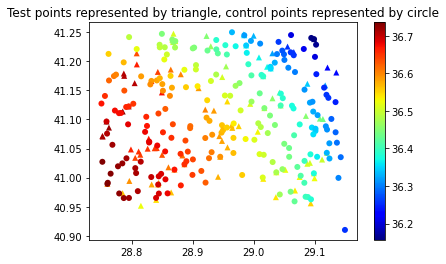

In [237]:
#Scatterplot of distribution
fig = plt.figure()

plt.scatter(testpoints_data["Longitude"],testpoints_data["Latitude"],edgecolors='none',c=testpoints_data["N"], marker= "^", cmap = cm.jet)
plt.scatter(controlpoints_data["Longitude"],controlpoints_data["Latitude"],edgecolors='none',c=controlpoints_data["adjustedN"], marker= "o", cmap = cm.jet)
plt.colorbar()
plt.title('Test points represented by triangle, control points represented by circle')

